100%|█████████████████████████████████████| 41159/41159 [15:30<00:00, 44.24it/s]


X_train (92607, 324)
X_valid (15435, 324)
X_test (15435, 324)
Y_train (92607, 21)
Y_valid (15435, 21)
Y_test (15435, 21)
[{'feature': [0, 24], 'target': [24, 29]}, {'feature': [6, 30], 'target': [30, 35]}, {'feature': [12, 36], 'target': [36, 41]}]


<AxesSubplot:>

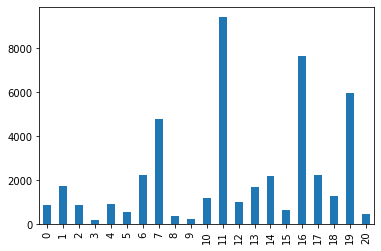

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.tree import DecisionTreeClassifier
from CrossSectionalInputDataGenerator import CrossSectionalInputDataGenerator

from Metrics import turn_predictions_into_binaries, plot_multilabel_pr_curve, \
create_classification_report_custom_binary_threshold,call_all_training_plots, plot_and_export_pr_tradeoffs_micro_average
from Models import grid_search_tune_dtree, randomly_tune_dtree

products_and_features_table = pd.read_pickle(
    'raw_data_1728678rows_x_77columns.pkl'
).drop(["DAX", "EUR_USD", "EURIBOR_ON", "EURIBOR_3M",
        "EURIBOR_12M", "LIBOR_USD_ON", "LIBOR_USD_3M", "LIBOR_USD_12M", "Oil"],axis=1)

csa_data = CrossSectionalInputDataGenerator(products_and_features_table)
csa_data.create_input_data()
input_data = csa_data.get_input_data()
feature_width = 324
input_data['X_train'] = input_data['X_train'].reshape((input_data['Y_train'].shape[0],feature_width))
input_data['X_valid'] = input_data['X_valid'].reshape((input_data['Y_valid'].shape[0],feature_width))
input_data['X_test'] = input_data['X_test'].reshape((input_data['Y_test'].shape[0],feature_width))
for input_data_key in input_data.keys():
    print(input_data_key, input_data[input_data_key].shape)
print(csa_data.time_windows)
pd.DataFrame(input_data['Y_train']).apply(
    pd.Series.value_counts).loc[1].plot(kind='bar')

In [2]:
import itertools
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
import tensorflow as tf
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm
from typing import List
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout

from Metrics import turn_predictions_into_binaries, create_classification_report_custom_binary_threshold


def compute_cf_recommendation(id: int, user_similarity: pd.DataFrame,
                              feature: pd.DataFrame,similarity_range:int) -> pd.Series:
    most_similar_clients = user_similarity.loc[id].dropna().sort_values(
        ascending=False).reset_index()
    most_similar_clients = most_similar_clients[
        most_similar_clients['customer_gpkenn'] != id]
    n_most_similar_clients_with_score = most_similar_clients.loc[:similarity_range]
    features_n_most_similar_clients = feature.loc[
        n_most_similar_clients_with_score['customer_gpkenn'].values]  #.loc[id]
    return features_n_most_similar_clients.multiply(n_most_similar_clients_with_score[id].values,axis='rows').mean(axis='rows')\
    #- feature.loc[id]


def compute_cf_recommendation_for_all_clients(feature,similarity_range) -> pd.DataFrame:
    user_similarity_active_clients = feature.T.corr()
    recommendation_scores_per_product = []
    for id in user_similarity_active_clients.index.values:
#    for id in tqdm(user_similarity_active_clients.index.values):    
        recommendation_scores_per_product.append(
            compute_cf_recommendation(id, user_similarity_active_clients,
                                      feature,similarity_range))
    recommender_scores_active_clients = pd.DataFrame(
        recommendation_scores_per_product, index=feature.index).fillna(0)
    return recommender_scores_active_clients

def calculate_and_merge_cf_predictions(cf_data_formatter,similarity_range):
    predictions = []
    for time_window in cf_data_formatter.time_windows:
        feature = cf_data_formatter.select_products_for_timeframe(
            time_window['feature'])
        predictions.append(compute_cf_recommendation_for_all_clients(feature,similarity_range))
    predictions = pd.concat(predictions)
    return train_test_split(predictions,test_size=0.125,shuffle=False)[1]
    
def evaluate_hparam_combination_collaborative_filter(hparams,cf_data_formatter,metric="f1-score"):
    merged_predictions = calculate_and_merge_cf_predictions(cf_data_formatter,hparams[0])
    merged_targets = cf_data_formatter.give_merged_targets()
    classification_report = create_classification_report_custom_binary_threshold(
        turn_predictions_into_binaries(merged_predictions.copy(), 0.05).to_numpy(),
        merged_targets.to_numpy(), cf_data_formatter.target_columns)
    return classification_report.loc["micro avg"][metric]

def grid_search_tune_collaborative_filter(hparams,cf_data_formatter,metric="f1-score") ->pd.DataFrame:
    all_hp_combinations = [*itertools.product(*hparams.values())]
    results = []
    for hparams_combination in tqdm(all_hp_combinations):
        evaluation = evaluate_hparam_combination_collaborative_filter(hparams_combination,cf_data_formatter,metric)
        results.append({"hparams":hparams_combination,"metric":evaluation})
    return pd.DataFrame(results).sort_values("metric",ascending=False).reset_index(drop=True)


def evaluate_hparam_combination_cs(hparams,input_data,csa_data,metric="f1-score"):
    dtree_classifier = DecisionTreeClassifier(criterion=hparams[0], max_depth=hparams[1], min_samples_split=hparams[2], \
                        min_samples_leaf=hparams[3],random_state=42)
    dtree_classifier = dtree_classifier.fit(input_data['X_train'],input_data['Y_train'])
    report_cross_section_approach = create_classification_report_custom_binary_threshold(
    turn_predictions_into_binaries(dtree_classifier.predict(input_data['X_test']), 0.5),
    input_data['Y_test'],csa_data.all_products)
    return report_cross_section_approach.loc["micro avg"][metric]

def randomly_tune_dtree(hparams,input_data,csa_data,runs,metric="f1-score") ->pd.DataFrame:
    results = []
    for _ in tqdm(range(runs)):
        random_hparams_combination = random.choice([*itertools.product(*hparams.values())])
        evaluation = evaluate_hparam_combination_cs(random_hparams_combination,input_data,csa_data,metric)
        results.append({"hparams":random_hparams_combination,"metric":evaluation})
    return pd.DataFrame(results).sort_values("metric",ascending=False).reset_index(drop=True)

def grid_search_tune_dtree(hparams,input_data,csa_data,metric="f1-score") ->pd.DataFrame:
    all_hp_combinations = [*itertools.product(*hparams.values())]
    results = []
    for hparams_combination in tqdm(all_hp_combinations):
        evaluation = evaluate_hparam_combination_cs(hparams_combination,input_data,csa_data,metric)
        results.append({"hparams":hparams_combination,metric:evaluation})
    return pd.DataFrame(results).sort_values(metric,ascending=False).reset_index(drop=True)


def build_lstm_for_tuning_rmsprop_generic(hp):
    activation=['tanh','sigmoid']
    lossfct='binary_crossentropy'
    hidden_units_first_layer = hp.Choice('neurons first layer',[32,64,128,256,512,1024])
    lr = hp.Choice('learning_rate', [0.005])
    momentum = hp.Choice('momentum', [0.9])
    epsilon = hp.Choice('epsilon', [1e-06])
    model = Sequential()
    model.add(LSTM(hidden_units_first_layer,input_shape=(24, 236),activation=activation[0]))
    model.add(Dense(units=21, activation=activation[1]))
    optimizer = tf.keras.optimizers.RMSprop(
    learning_rate=lr,momentum=momentum,epsilon=epsilon)
    model.compile(loss=lossfct, optimizer= optimizer,metrics=[tf.keras.metrics.Accuracy(),\
                                                          tf.keras.metrics.BinaryAccuracy(),\
                                                          tf.keras.metrics.MeanSquaredError(),\
                                                          tf.keras.metrics.Precision(),\
                                                          tf.keras.metrics.Recall(),\
                                                          tf.keras.metrics.TruePositives(),
                                                          tf.keras.metrics.AUC(multi_label=True)
                                                          ])
    return model



def build_lstm_for_tuning_rmsprop_specific(hp):
    activation=['tanh','sigmoid']
    lossfct='binary_crossentropy'
    hidden_units_first_layer = hp.Choice('neurons first layer',[1024])
    lr = hp.Choice('learning_rate', [0.005])
    momentum = hp.Choice('momentum', [0.9])
    epsilon = hp.Choice('epsilon', [1e-06])
    model = Sequential()
    model.add(LSTM(hidden_units_first_layer,input_shape=(24, 236),activation=activation[0]))
    model.add(Dense(units=21, activation=activation[1]))
    optimizer = tf.keras.optimizers.RMSprop(
    learning_rate=lr,momentum=momentum,epsilon=epsilon)
    model.compile(loss=lossfct, optimizer= optimizer,metrics=[tf.keras.metrics.Accuracy(),\
                                                          tf.keras.metrics.BinaryAccuracy(),\
                                                          tf.keras.metrics.MeanSquaredError(),\
                                                          tf.keras.metrics.Precision(),\
                                                          tf.keras.metrics.Recall(),\
                                                          tf.keras.metrics.TruePositives(),
                                                          tf.keras.metrics.AUC(multi_label=True)
                                                          ])
    return model

In [3]:
hparams = {"criterion":['gini','entropy'],"max_depth":[10,25,50,100,200],"min_samples_split":[2,5,10,50],"min_samples_leaf":[10,25,50,100,200]}
tuning_results = grid_search_tune_dtree(hparams,input_data,csa_data)
print(tuning_results)

100%|█████████████████████████████████████████| 200/200 [29:29<00:00,  8.85s/it]

                     hparams  f1-score
0         (gini, 200, 2, 50)  0.493800
1        (gini, 100, 50, 50)  0.493800
2          (gini, 50, 2, 50)  0.493800
3          (gini, 50, 5, 50)  0.493800
4         (gini, 50, 10, 50)  0.493800
..                       ...       ...
195  (entropy, 200, 50, 200)  0.393310
196   (entropy, 10, 10, 200)  0.360422
197   (entropy, 10, 50, 200)  0.360422
198    (entropy, 10, 5, 200)  0.360422
199    (entropy, 10, 2, 200)  0.360422

[200 rows x 2 columns]


                                 precision    recall  f1-score  support
Asset Management                  0.500000  0.239130  0.323529    138.0
Aval                              0.529412  0.059801  0.107463    301.0
Betriebliche Altersvorsorge       0.707071  0.448718  0.549020    156.0
Bond-Emissionen                   0.000000  0.000000  0.000000     39.0
Bürgschaften und Garantien        0.000000  0.000000  0.000000    142.0
Cash Pooling                      0.945946  0.388889  0.551181     90.0
Commerz Real - Mobilienleasing    0.592593  0.041237  0.077108    388.0
Export Dokumentengeschäft         0.633705  0.613208  0.623288    742.0
Export- und Handelsfinanzierung   0.500000  0.163265  0.246154     49.0
Forderungsmanagement              0.000000  0.000000  0.000000     51.0
Geldmarktkredit                   0.000000  0.000000  0.000000    191.0
Global Payment Plus               0.752590  0.837288  0.792683   1475.0
Import Dokumentengeschäft         0.508772  0.200000  0.287129  

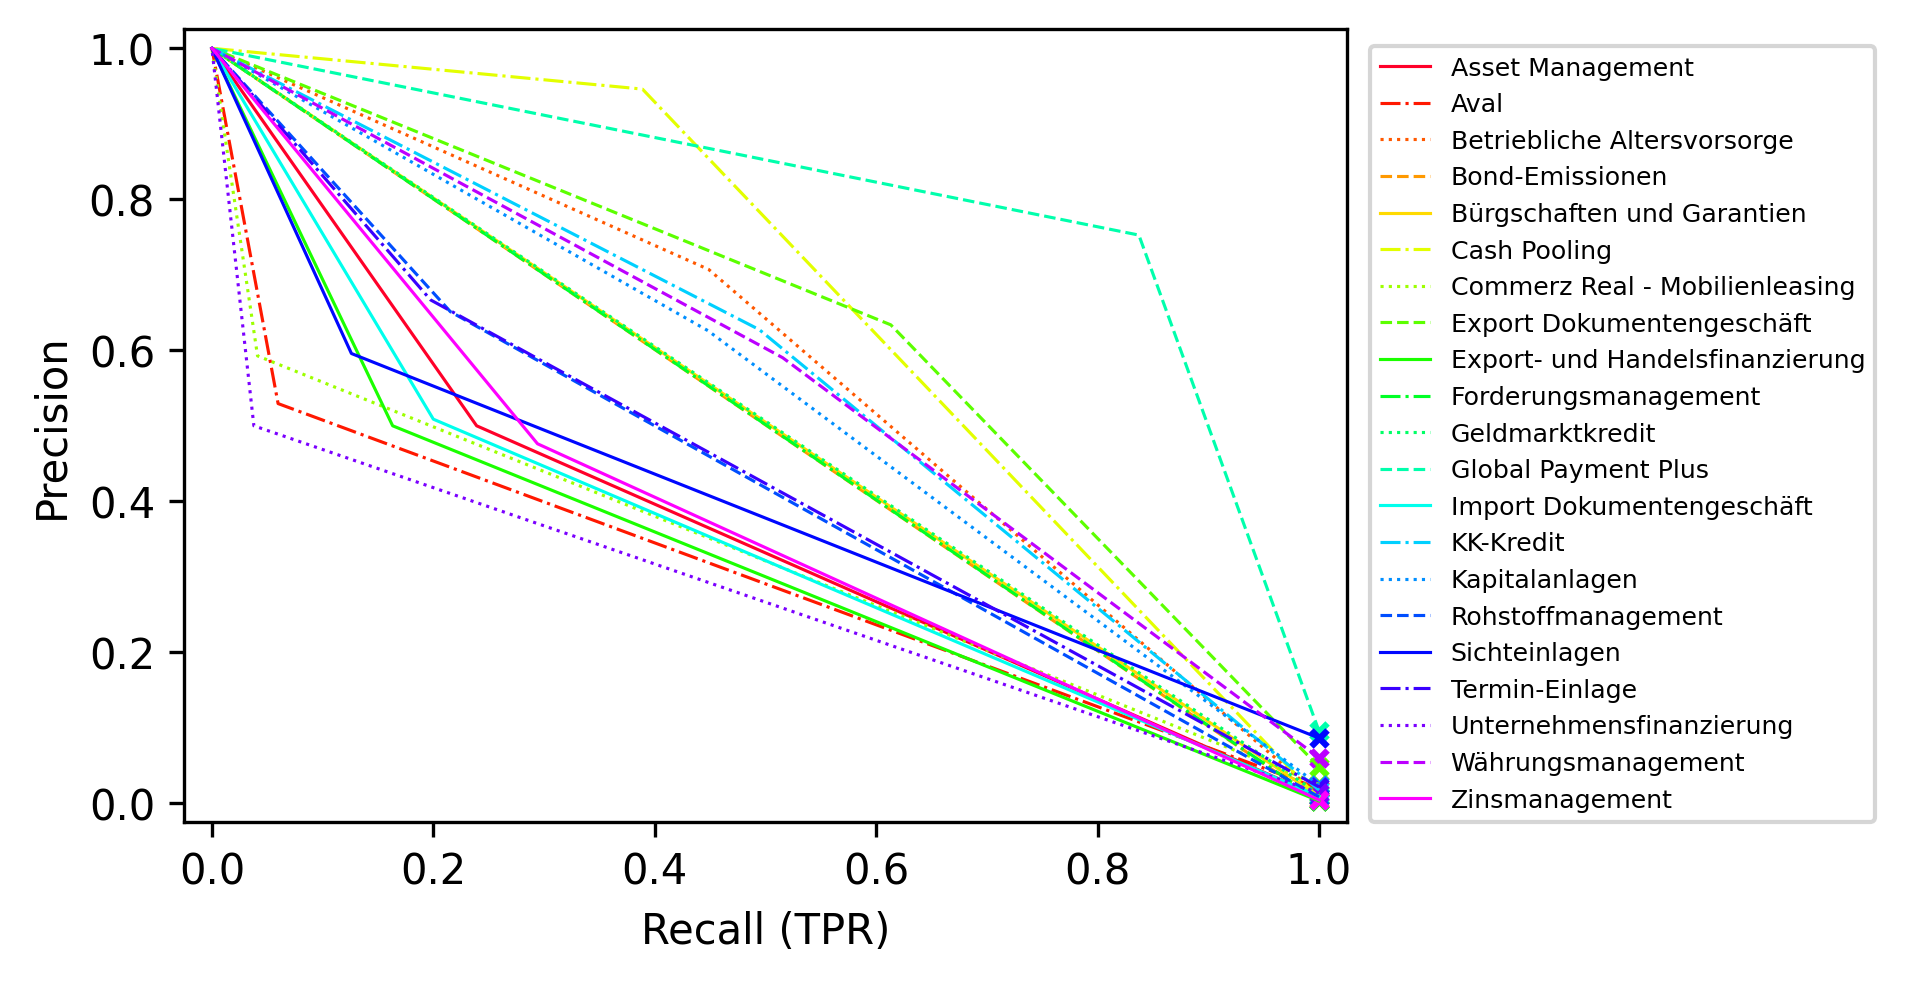

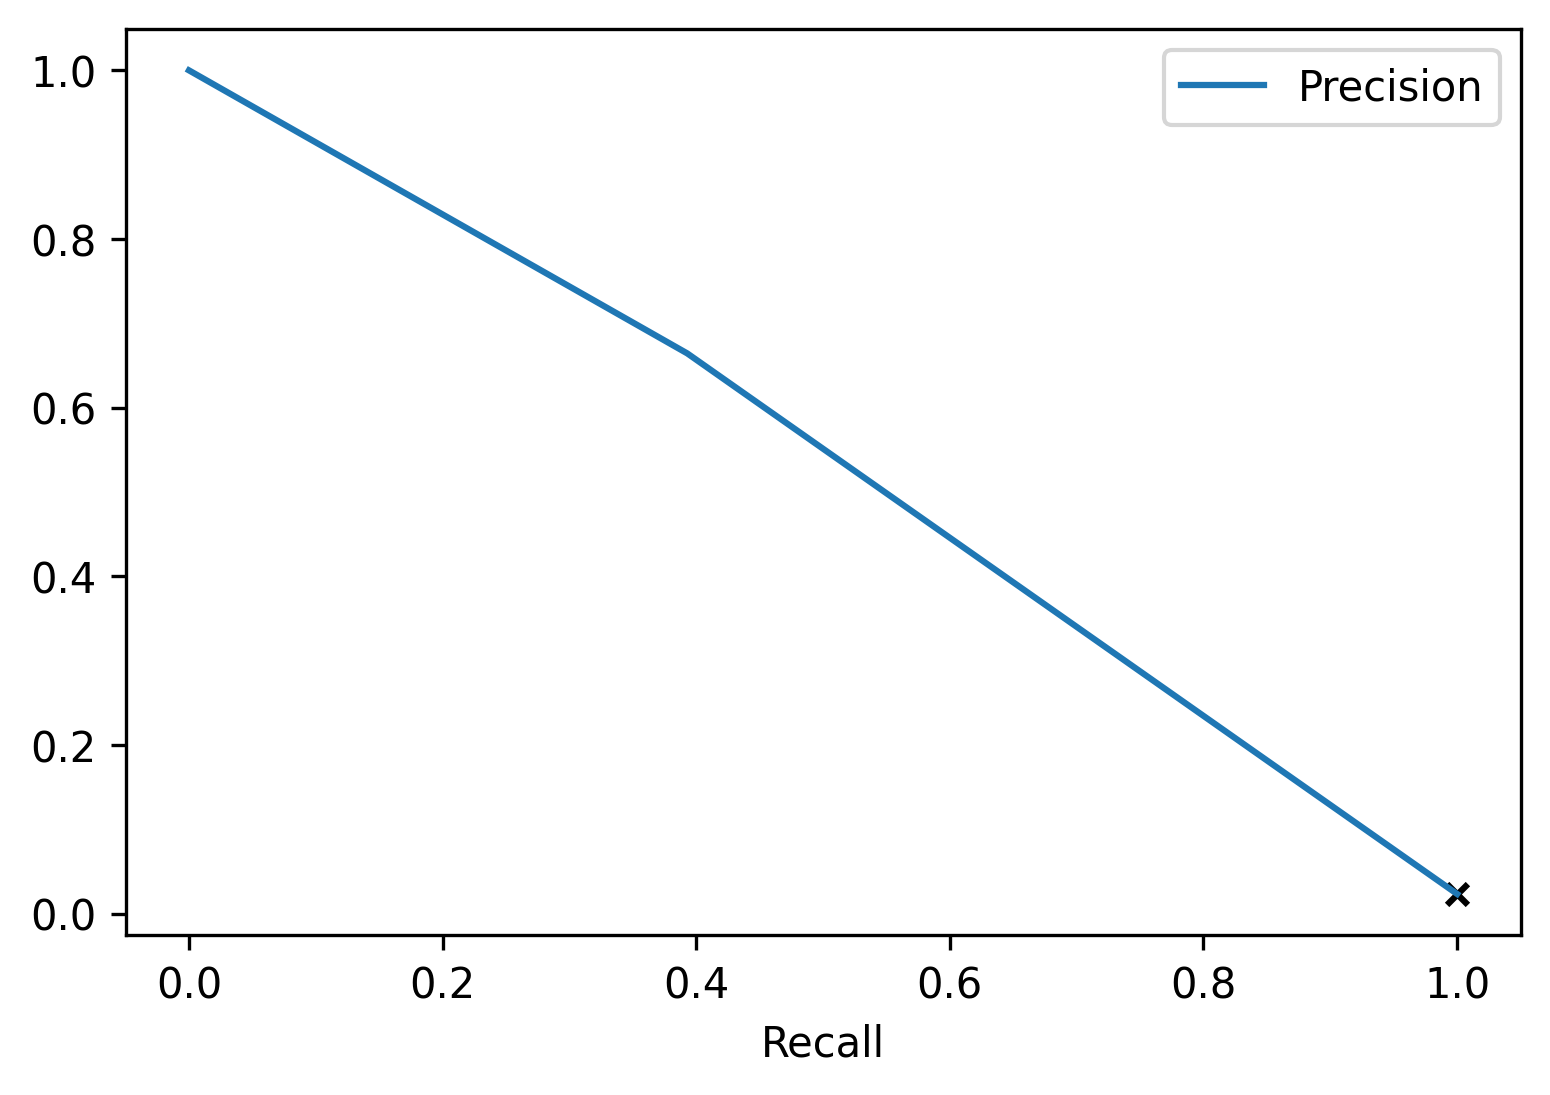

In [4]:
tuned_dtree = DecisionTreeClassifier(criterion=tuning_results.loc[0]["hparams"][0], max_depth=tuning_results.loc[0]["hparams"][1],\
    min_samples_split=tuning_results.loc[0]["hparams"][2],min_samples_leaf=tuning_results.loc[0]["hparams"][3],random_state=42)\
    .fit(input_data['X_train'],input_data['Y_train'])

report_cross_section_approach = create_classification_report_custom_binary_threshold(
    turn_predictions_into_binaries(tuned_dtree.predict(input_data['X_test']), 0.5),
    input_data['Y_test'],csa_data.all_products)
print(report_cross_section_approach[["precision","recall","f1-score","support"]])
report_cross_section_approach.to_pickle("classification_report_cross_section_approach.pkl")
plot_multilabel_pr_curve(tuned_dtree.predict(input_data['X_test']),input_data['Y_test'],csa_data.all_products,"pr_curve_cross_section_approach.png")
plot_and_export_pr_tradeoffs_micro_average(tuned_dtree.predict(input_data['X_test']), input_data['Y_test'],"cross_section")